In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv(f'../03.dataset/TPE_model_features_clean.csv')

In [3]:
data_class = pd.get_dummies(data['鄉鎮市區'])
#data = data.loc[data['交易標的'] == 0]
data_class.columns = ['鄉鎮市區_' + str(x) for x in data_class.columns]
data = pd.concat([data, data_class], axis = 1)
print(data.shape[1])

116


In [4]:
data.insert(data.shape[1], 'y', data['單價元平方公尺'])
data.drop(['單價元平方公尺'],axis=1,inplace=True)
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(['Unnamed: 0.1'],axis=1,inplace=True)
data.drop(['Unnamed: 0.2'],axis=1,inplace=True)
data.drop(['鄉鎮市區'],axis=1,inplace=True)
#data = data.loc[data['備註'].isnull()]
#data.drop(['備註'],axis=1,inplace=True)
data.drop(['geometry'],axis=1,inplace=True)

In [5]:
data = data.loc[:, data.std() > 0.2]
data = data.dropna()

In [6]:
test_data = data.loc[data['交易年份'] >= 111]
train_data =  data.loc[data['交易年份'] < 111]

In [7]:
feature_count = data.shape[1]

In [8]:
mean = train_data.mean()
std = train_data.std()
train_data = (train_data-mean)/std

In [9]:
X_train = np.array(train_data.drop('y', axis='columns'))
y_train = np.array(train_data['y'])

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
model_mlp = MLPRegressor(max_iter = 400,activation='relu', hidden_layer_sizes=(int(data.shape[1]*1/2),int(data.shape[1]*1/4)))
model_mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(47, 23), max_iter=400)

In [12]:
model_rf = RandomForestRegressor(n_estimators=50,min_samples_leaf=3)
model_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3, n_estimators=50)

In [13]:
def mix_predictions(Features):
    return ((0.5 * model_mlp.predict(Features)) + (0.5 * model_rf.predict(Features)))

In [14]:
test_data = (test_data - mean) / std
#test_data = test_data.loc[test_data['y'] >= 3]
X_test = np.array(test_data.drop('y', axis='columns'))
y_test = np.array(test_data['y'])

In [15]:
result = mix_predictions(X_test)

In [16]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': result})
df1 = df.head(10)
df1

,Actual,Predicted
0,-0.989601,-0.685938
1,1.315203,1.692717
2,-0.092230,0.039968
3,0.651602,0.479363
4,-0.313998,-0.329945
5,0.686458,0.877038
6,0.053833,1.204897
7,0.500445,0.467325
8,-1.220107,-0.693569
9,1.236391,1.426386


C:\Users\tazz4\anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

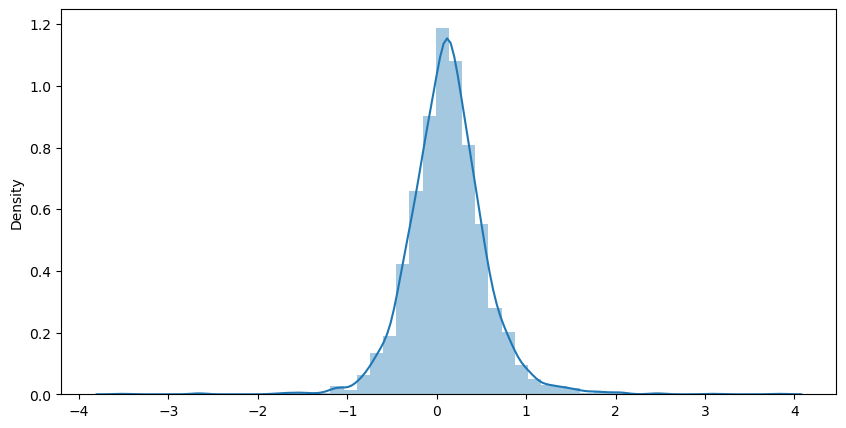

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10,5))
residuals = (y_test- result)
sns.distplot(residuals)

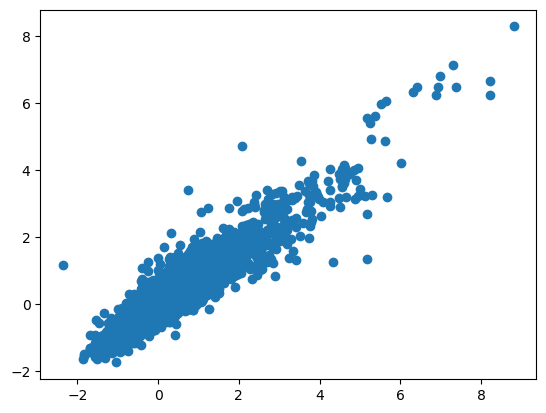

In [18]:
plt.scatter(y_test, result)
plt.plot([0,1],[0,1])

In [19]:
data1 = pd.DataFrame({'origin':y_test * std['y'] + mean['y'],'predict':result* std['y'] + mean['y'],
                     'residual':(y_test * std['y'] + mean['y']) - (result* std['y'] + mean['y'])})
percentage_error = np.mean(np.abs(data1['origin'] - data1['predict'])) / np.mean(data1['origin']) * 100
data1['residual_abs'] = data1['residual'].abs()
data1['y10'] = data1['origin'] / 10 - data1['residual_abs']
data1['y20'] = data1['origin'] / 5 - data1['residual_abs']
data1['y30'] = data1['origin'] / 3.333 - data1['residual_abs']
data1.loc[data1['y10'] >= 0, 'y10'] = 1
data1.loc[data1['y10'] < 0 , 'y10'] = 0
data1.loc[data1['y20'] >= 0, 'y20'] = 1
data1.loc[data1['y20'] < 0 , 'y20'] = 0
data1.loc[data1['y30'] >= 0, 'y30'] = 1
data1.loc[data1['y30'] < 0 , 'y30'] = 0
print(data1)
print(f'預測房價落在實際房價+-10%內的機率為:{data1["y10"].mean()}')
print(f'預測房價落在實際房價+-20%內的機率為:{data1["y20"].mean()}')
print(f'預測房價落在實際房價+-30%內的機率為:{data1["y30"].mean()}')
print("Model Percentage Error: {:.2f}%".format(percentage_error))

        origin        predict      residual  residual_abs  y10  y20  y30
0     120253.0  139506.448567 -19253.448567  19253.448567  0.0  1.0  1.0
1     266387.0  290322.905104 -23935.905104  23935.905104  1.0  1.0  1.0
2     177150.0  185531.852600  -8381.852600   8381.852600  1.0  1.0  1.0
3     224312.0  213391.316844  10920.683156  10920.683156  1.0  1.0  1.0
4     163089.0  162077.862991   1011.137009   1011.137009  1.0  1.0  1.0
...        ...            ...           ...           ...  ...  ...  ...
3162  114342.0  111027.173221   3314.826779   3314.826779  1.0  1.0  1.0
3163  191966.0  198412.754851  -6446.754851   6446.754851  1.0  1.0  1.0
3164  199075.0  179321.230824  19753.769176  19753.769176  1.0  1.0  1.0
3165  225828.0  234432.330091  -8604.330091   8604.330091  1.0  1.0  1.0
3166  350368.0  295408.745908  54959.254092  54959.254092  0.0  1.0  1.0

[3167 rows x 7 columns]
預測房價落在實際房價+-10%內的機率為:0.6021471424060625
預測房價落在實際房價+-20%內的機率為:0.904957372908115
預測房價落在實際房價+-30%內的機率為

In [20]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print(f"mean_absolute_error: {mean_absolute_error(y_test, result)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, result)}")
print(f"mean_squared_error: {mean_squared_error(y_test, result)}")
print(f"explained_variance_score: {explained_variance_score(y_test, result)}")
print(f"r2_score: {r2_score(y_test, result)}")

mean_absolute_error: 0.3287562521597152
mean_absolute_percentage_error: 2.5668246217804374
mean_squared_error: 0.2047315025067406
explained_variance_score: 0.8693734985964219
r2_score: 0.8595068243312409
